In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change the directory to your own working directory
import os
os.chdir('/content/drive/MyDrive/')

In [3]:
# SIFT requirement 
# (need OpenCV version 4.5 or later)
!pip install opencv-python==4.5.3.*

     |████████████████████████████████| 49.9 MB 17 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
# Import library modules
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
# PIL is the Python Imaging Library
from PIL import Image  
# The following is a substitute for cv2.imshow, which Colab does not allow
from google.colab.patches import cv2_imshow

print('Python version:', sys.version)
print('OpenCV version:', cv2.__version__)
print('NumPy version: ', np.__version__)

Python version: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
OpenCV version: 4.5.3
NumPy version:  1.19.5


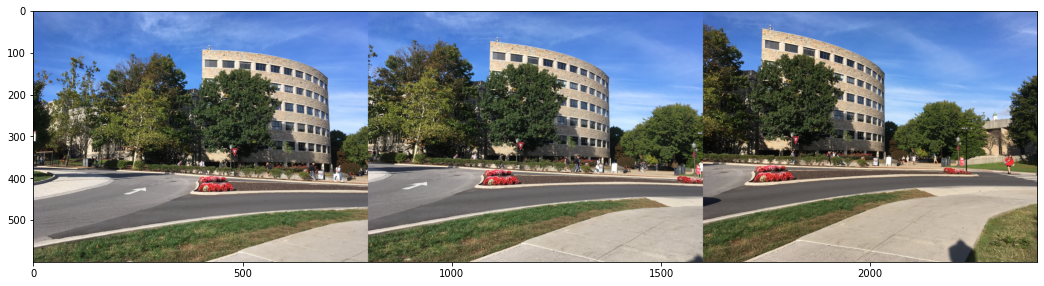

In [5]:
def load_image(filename):
  img = np.asarray(Image.open(filename))
  img = img.astype("float32")/255.0
  return img

def show_image(img):
  fig = plt.figure()
  fig.set_size_inches(18, 10) # You can adjust the size of the displayed figure
  plt.imshow(img)

left_img = load_image("Newman1.png")
center_img = load_image("Newman2.png")
right_img = load_image("Newman3.png")
show_image(np.concatenate([left_img, center_img, right_img], axis=1))

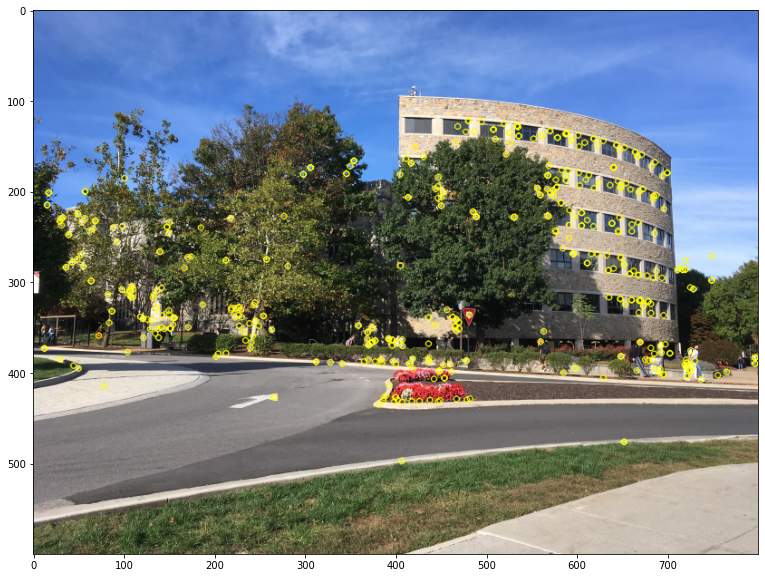

In [6]:
def testSIFT(img1):
  sift = cv2.SIFT_create(nfeatures=500)
  kp = sift.detect(img1, None)
  img1=cv2.drawKeypoints(img1, kp, None, color=(0, 255, 255))
  
  fig = plt.figure()
  fig.set_size_inches(18,10) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))


img = cv2.imread("Newman1.png", cv2.IMREAD_COLOR)
testSIFT(img)

In [7]:
def compute_homography(src_pts, dst_pts):
  # Computes the homography from src to dst
  N = src_pts.shape[0]

  H=[]
  src_array = np.asarray(src_pts)
  dst_array = np.asarray(dst_pts)

  for n in range(N):
    src = src_array[n]
    H.append(-src[0])
    H.append(-src[1])
    H.append(-1)
    H.append(0)
    H.append(0)
    H.append(0)

  H = np.asarray(H)
  H1 = H.reshape(2*N,3)

  H2 = np.zeros([2*N, 3], dtype=int)
  for i in range(0,2*N,2):
    H2[i:i+2,0:i+3] = np.flip(H1[i:i+2,0:i+3], axis=0)

  H2 = np.asarray(H2)
  H3 = np.concatenate((H1, H2), axis=1)

  H4=[]
  for n in range(N):
    src = src_array[n]
    dst = dst_array[n]

    H4.append(src[0]*dst[0])
    H4.append(src[1]*dst[0])
    H4.append(dst[0])
    H4.append(src[0]*dst[1])
    H4.append(src[1]*dst[1])
    H4.append(dst[1])

  H4 = np.asarray(H4)
  H4 = H4.reshape(2*N,3)

  H5 = np.concatenate((H3, H4), axis=1)
  H8 = np.matmul(np.transpose(H5), H5)

  ## SVD Implementation
  # U, S, Vh = np.linalg.svd(H5)
  # L = Vh[-1,:] / Vh[-1,-1]
  # H = L.reshape(3, 3)
  # #print(H)

  w, v = np.linalg.eig(H8)
  #print(w,v)
  minimum = w.min()
  #print(minimum)
  for i in range(len(w)):
    if w[i] == minimum:
      a = v[:, i]

  a = np.asarray(a)
  a = a.reshape(3,3)
  a = a/a[2,2] # Normalizing

  return a


def apply_homography(test, H):
  # Applying homography to the test image
  dst_output = []
  N = test.shape[0]

  for row in test:
    input = np.matrix([row[0,0], row[0,1], 1])
    input = input.transpose()
    mapped_pts = np.matmul(H, input)
    dst_output.append(mapped_pts[0]/mapped_pts[2])
    dst_output.append(mapped_pts[1]/mapped_pts[2])

  dst_output = np.asarray(dst_output)
  dst_output = dst_output.reshape(N, 2)
  
  return dst_output

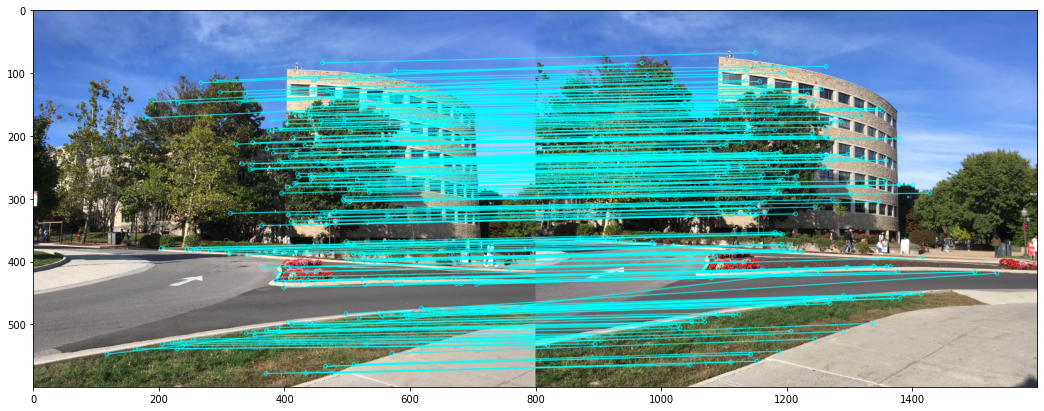

In [12]:
# Visualizing keypoint matches from SIFT

def genSIFTMatchPairs(img1, img2):
  sift = cv2.SIFT_create()
  kp1, des1 = sift.detectAndCompute(img1, None)
  kp2, des2 = sift.detectAndCompute(img2, None)
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  matches = bf.match(des1, des2)
  matches = sorted(matches, key = lambda x:x.distance)

  pts1 = np.zeros((250, 2))
  pts2 = np.zeros((250, 2))
  for i in range(250):
    pts1[i,:] = kp1[matches[i].queryIdx].pt
    pts2[i,:] = kp2[matches[i].trainIdx].pt

  return pts1, pts2, matches[:250], kp1, kp2

def test_matches():
  img1 = cv2.imread('Newman1.png')
  img2 = cv2.imread('Newman2.png')
  pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img1, img2)

  # In the following, parameter flags=2 will remove unmatched points from the display
  matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches1to2, None, flags=2,
    matchColor = (255, 255, 0), singlePointColor=(0, 0, 255))
  
  fig = plt.figure()
  fig.set_size_inches(18,10) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

test_matches()

Notice that some of the matches from the previous step are not correct. It is possible that those false matches could act as outliers in your homography estimation. In that case we would expect a poor result in any composite image that we create. 

As discussed during lectures, the RANSAC algorithm is a popular way to deal with outliers during model fitting. Here you must implement your own function that uses the RANSAC approach to compute a homography H. 

In [13]:
# RANSAC using SIFT keypoints

import random
def RANSAC(Xs, Xd, max_iter, eps):
  '''Find correspondences between two sets of points using the RANSAC algorithm.
   Input:
    Xs: the first set of points (source), shape [n, 2]
    Xd: the second set of points (destination) matched to the first set, shape [n, 2] 
    max_iter: max number of iterations that RANSAC should perform
    eps: tolerance of RANSAC
   Output:
    best_inliers_id: the indices of matched pairs when using the homography given by RANSAC
    H: the computed homography, shape [3, 3]

   TO DO: Implement the RANSAC function.
  '''
  H = np.zeros([3,3])
  

  inliers_ids = []
  inliers_counts = []

  n = Xs.shape[0]

  iter = 0
  while iter < max_iter:
    inliers_id = []
    pts_index = random.sample(range(0, n), 4)

    Xs_new = []
    Xd_new = []

    for pt in range(4):
      Xs_new.append(Xs[pts_index[pt]][:])
      Xd_new.append(Xd[pts_index[pt]][:])

    Xs_new = np.asarray(Xs_new)
    Xd_new = np.asarray(Xd_new)
    Xs_new = np.asmatrix(Xs_new)
    Xd_new = np.asmatrix(Xd_new)

    H = compute_homography(Xs_new, Xd_new)

    Xs = np.asmatrix(Xs)
    Xd_predicted = apply_homography(Xs, H)

    for i in range(n):
      #SSD += ((round(Xd_predicted[i][0]) - round(Xd[i][0])) + (round(Xd_predicted[i][1]) - round(Xd[i][1])))**2
      #SSD += ((round(Xd_predicted[i][0]) - int(Xd[i, 0]))**2 + (round(Xd_predicted[i][1]) - int(Xd[i, 1]))**2)
      SSD = ((round(Xd_predicted[i][0]) - int(Xd[i, 0]))**2 + (round(Xd_predicted[i][1]) - int(Xd[i, 1]))**2)
      #print(round(Xd_predicted[i][0]))
      #print(int(Xd[i, 0]))

      if SSD < eps:
        if i not in inliers_id:
          inliers_id.append(i)
    
    inliers_ids.append(inliers_id)
    inliers_counts.append(len(inliers_id))
    
    iter += 1

  largest_count_index = inliers_counts.index(max(inliers_counts))
  best_inliers_id = inliers_ids[largest_count_index]

  Xs_inliers = []
  Xd_inliers = []
  for i in best_inliers_id:
    Xs_inliers.append(Xs[i][:])
    Xd_inliers.append(Xd[i][:])

  Xs_inliers = np.asarray(Xs_inliers)
  Xd_inliers = np.asarray(Xd_inliers)
  Xs_inliers = np.asmatrix(Xs_inliers)
  Xd_inliers = np.asmatrix(Xd_inliers)

  #print(len(Xs_inliers))
  #print(len(Xd_inliers))
  H = compute_homography(Xs_inliers, Xd_inliers)

  return best_inliers_id, H

[[ 1.26252232e+00 -1.46940014e-02 -1.78499281e+02]
 [ 1.14222438e-01  1.16291262e+00 -7.10008229e+01]
 [ 3.13778639e-04  4.03515356e-05  1.00000000e+00]]
242


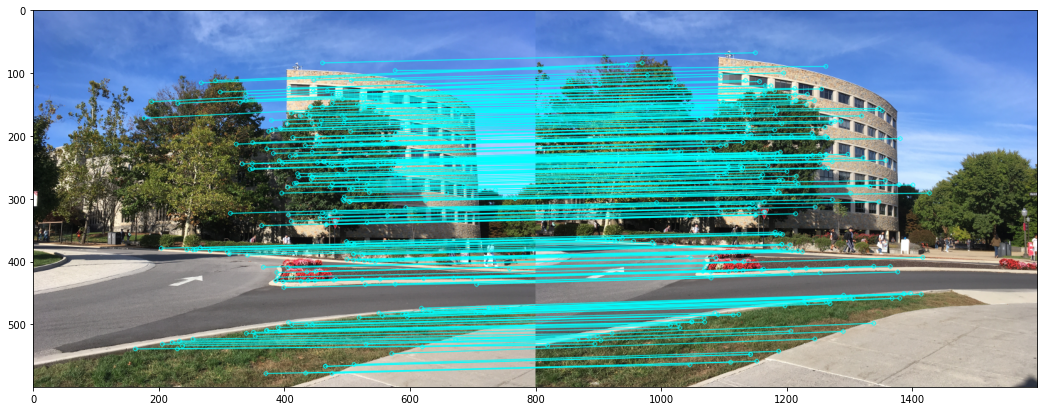

In [14]:
def test_ransac():
  img1 = cv2.imread('Newman1.png')
  img2 = cv2.imread('Newman2.png')
  pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img1, img2)
  #print(pts1)
  inliers_idx, H = RANSAC(pts1, pts2, 500, 50)
  print(H)
  print(len(inliers_idx))
  new_matches = []
  for i in range(len(inliers_idx)):
    new_matches.append(matches1to2[inliers_idx[i]])

  matching_result = cv2.drawMatches(img1, kp1, img2, kp2, new_matches, None, flags=2, 
                                    matchColor = (255, 255, 0), singlePointColor=(0, 0, 255))

  fig = plt.figure()
  fig.set_size_inches(18, 10) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

test_ransac()

In [15]:
# IMAGE STITCHING

def stitch_img(imgs):
  '''Stitch a list of images together.
   Input:
    imgs: a list of images.
   Output:
    stitched_img: a single stiched image.
  
   TO DO: implement the stitch_img function.
  '''
  # the following line is just a placeholder
  img0 = imgs[0]
  img1 = imgs[1]
  img2 = imgs[2]

  img0 = np.pad(img0, pad_width=((400, 400), (400,400), (0,0)))
  #show_image(img1)

  pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img1, img0)
  inliers_idx, H = RANSAC(pts1, pts2, 500, 50)

  dst_img = warp_img(img1, H, [img0.shape[0], img0.shape[1]])

  dst_mask = 1 - binary_mask(dst_img)
  dst_mask = np.stack((dst_mask,) * 3, -1)
  out_img = np.multiply(img0, dst_mask) + dst_img

  pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img2, img0)
  inliers_idx, H = RANSAC(pts1, pts2, 500, 50)

  dst_img = warp_img(img2, H, [out_img.shape[0], out_img.shape[1]])

  dst_mask = 1 - binary_mask(dst_img)
  dst_mask = np.stack((dst_mask,) * 3, -1)
  out_img1 = np.multiply(out_img, dst_mask) + dst_img


  return out_img1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.


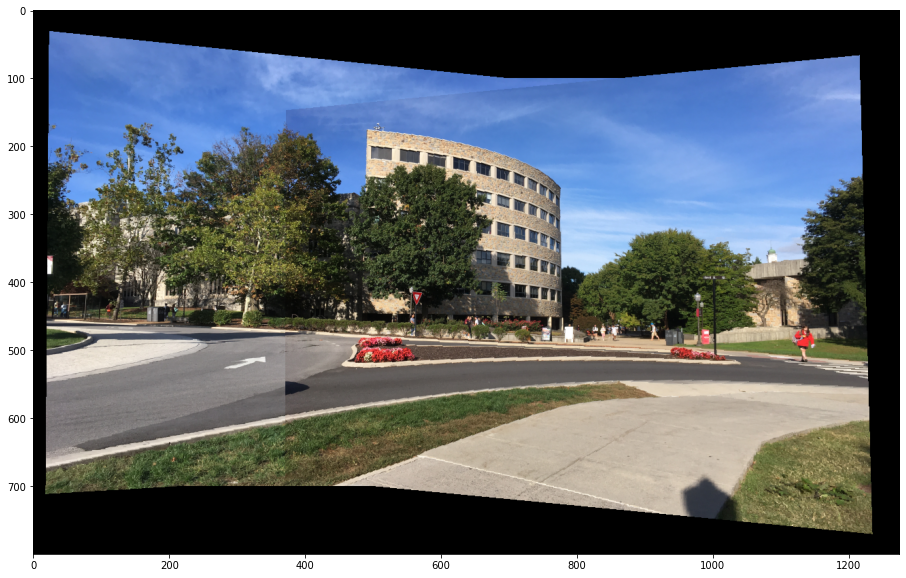

In [16]:
left_img = cv2.imread("Newman1.png")
center_img = cv2.imread("Newman2.png")
right_img = cv2.imread("Newman3.png")

final_stitch = stitch_img([center_img, left_img, right_img])

fig = plt.figure()
fig.set_size_inches(25,10) 
plt.imshow(cv2.cvtColor(final_stitch[300:final_stitch.shape[0]-300, 200:final_stitch.shape[1]-125].astype("uint8"), cv2.COLOR_BGR2RGB)) 

Finally, use 3 or more photos of your own to create a panorama. It is suggested that you take new photos using your camera (e.g., with your phone or laptop). Remember to stand in place and try to rotate the camera about its point of projection. (If the camera position changes, then the transformation between 2 images is no longer a homography.)

**Please include these new photos as part of your HW3 submission.** We would like to select the best panoramas (as decided by the graders) to show during a lecture. (If you prefer that we do not show your photos to the class, that is fine. In that case, please tell us using a comment at the top of the following code block.) To reduce computation time, it is acceptable to resize your images down to a smaller size before processing them. You could consider using `cv2.resize()` for that purpose. For example, the provided Newman Library images were reduced to 800x600 from much larger dimensions.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.


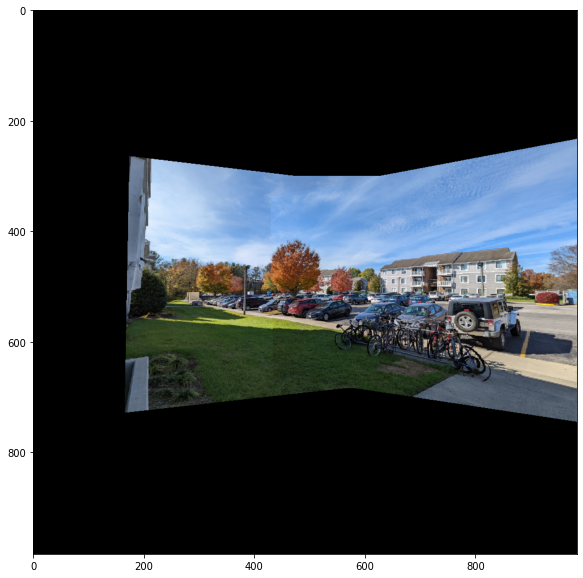

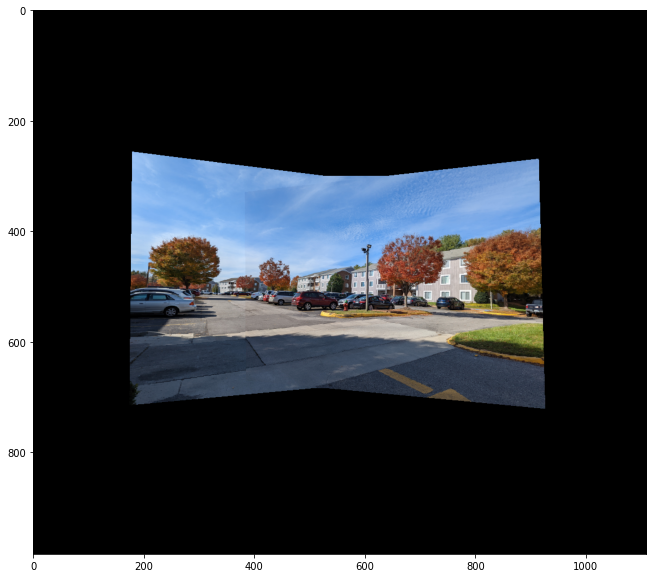

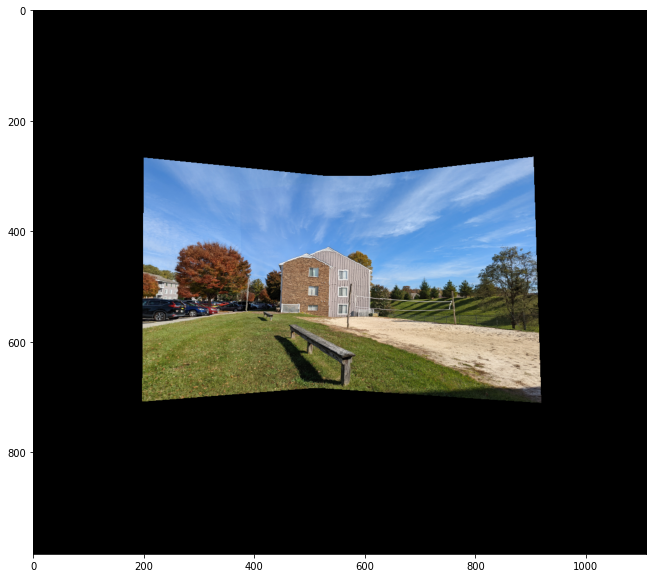

In [17]:
# Load your own images here and create a panorama. 
# Three images are shown here as examples for image stitching

trial_1 = cv2.imread('images/1_1.jpg')
trial_2 = cv2.imread('images/1_2.jpg')
trial_3 = cv2.imread('images/1_3.jpg')

resized_1 = cv2.resize(trial_1, (510, 384), interpolation = cv2.INTER_AREA)
resized_2 = cv2.resize(trial_2, (510, 384), interpolation = cv2.INTER_AREA)
resized_3 = cv2.resize(trial_3, (510, 384), interpolation = cv2.INTER_AREA)

final_stitch = stitch_img([resized_2, resized_1, resized_3])

fig = plt.figure()
fig.set_size_inches(25,10) 
plt.imshow(cv2.cvtColor(final_stitch[100:final_stitch.shape[0]-100, 100:final_stitch.shape[0]-100].astype("uint8"), cv2.COLOR_BGR2RGB))

trial_1 = cv2.imread('images/2_1.jpg')
trial_2 = cv2.imread('images/2_2.jpg')
trial_3 = cv2.imread('images/2_3.jpg')

resized_1 = cv2.resize(trial_1, (510, 384), interpolation = cv2.INTER_AREA)
resized_2 = cv2.resize(trial_2, (510, 384), interpolation = cv2.INTER_AREA)
resized_3 = cv2.resize(trial_3, (510, 384), interpolation = cv2.INTER_AREA)


final_stitch = stitch_img([resized_2, resized_1, resized_3])

fig = plt.figure()
fig.set_size_inches(25,10) 
plt.imshow(cv2.cvtColor(final_stitch[100:final_stitch.shape[0]-100, 100:final_stitch.shape[1]-100].astype("uint8"), cv2.COLOR_BGR2RGB))

trial_1 = cv2.imread('images/3_1.jpg')
trial_2 = cv2.imread('images/3_2.jpg')
trial_3 = cv2.imread('images/3_3.jpg')

resized_1 = cv2.resize(trial_1, (510, 384), interpolation = cv2.INTER_AREA)
resized_2 = cv2.resize(trial_2, (510, 384), interpolation = cv2.INTER_AREA)
resized_3 = cv2.resize(trial_3, (510, 384), interpolation = cv2.INTER_AREA)


final_stitch = stitch_img([resized_2, resized_1, resized_3])

fig = plt.figure()
fig.set_size_inches(25,10) 
plt.imshow(cv2.cvtColor(final_stitch[100:final_stitch.shape[0]-100, 100:final_stitch.shape[1]-100].astype("uint8"), cv2.COLOR_BGR2RGB))